In [82]:
import sys
sys.path.append('..')
from db1 import *

R = PolynomialRing(QQ, 't')
S = PolynomialRing(ZZ, 't')
t = R.gen()

def is_paving(M):
    n = M.size()
    r = M.rank()
    return (len(M.independent_r_sets(r-1)) == binomial(n, r-1))

def q_kl(k, h):
    return kazhdan_lusztig_inverse_uniform(k, h+1) - kazhdan_lusztig_inverse_uniform(k-1, h)

def kl_inverse_fast(M):
    if M.loops(): return R(0)
    k, n = M.rank(), M.size()
    if k == n or k == 0: return R(1)
    if not M.is_connected():
        ans = R(1)
        CC = M.components()
        for N in CC:
            res = M.delete(M.groundset() - N)
            ans = ans * kl_inverse_fast(res)
        return ans

    if is_paving(M):
        return kl_inverse_paving(M)
    if is_paving(M.dual()):
        return kl_inverse_copaving(M)
    """
    if n <= 8 and M.is_connected():
        for i in range(len(mat[n][k])):
            if mat[n][k][i].is_isomorphic(M):
                return ikl[n][k][i]
    """
    LF = M.lattice_of_flats()
    ans = R(0)
    for F in LF:
        if len(F) != n:
            Res = M.delete(M.groundset() - F)
            Con = M.contract(F)
            chi = characteristic_polynomial(Con)(1/t) * t**(Con.rank())
            PPP = kl_inverse_fast(Res)(t) * (-1)**(Res.rank())
            ans = ans + chi * PPP
    assert (t**k * ans(1/t)).numerator() == -ans(t)
    ans = ans.numerator() * (-1)**(k+1)
    return ans.truncate((k+1)//2)

def kazhdan_lusztig_inverse_uniform(k, n):
    if k == n:
        return R(1)
    d = k
    m = n - d
    ans = 0
    for j in range((d-1)//2 + 1):
        ans = ans + m * (d-2*j)/((m+j) * (m+d-j)) * binomial(d, j) * t**j
    return ans * binomial(m+d, d)

def kl_inverse_paving(M):
    assert is_paving(M)
    n = M.size()
    k = M.rank()
    ans = kazhdan_lusztig_inverse_uniform(k, n)
    for H in M.hyperplanes():
        h = len(H)
        if h >= k:
            ans = ans - q_kl(k, h)
    return ans

def kl_inverse_copaving(M):
    assert is_paving(M.dual())
    n = M.size()
    k = M.rank()
    ans = kazhdan_lusztig_inverse_uniform(k, n)
    for H in M.dual().hyperplanes():
        h = len(H)
        if h >= n-k:
            ans = ans - kli_vtilde_dual(n-k, h, n) + kazhdan_lusztig_inverse_uniform(h-n+k+1, h) * kazhdan_lusztig_inverse_uniform(n-h-1, n-h)
    return ans

def kli_vtilde_dual(k, h, n):
    return helper1(n-k, h, n)

def helper1(k, h, n):
    c = n - h
    ans1 = kazhdan_lusztig_inverse_uniform(k, n)
    ans2 = helper2(c, k, n)
    ans3 = kazhdan_lusztig_inverse_uniform(k-c+1, h) * kazhdan_lusztig_inverse_uniform(c-1, c)
    return ans1 - ans2 + ans3

def helper2(c, k, n):
    h = n - c
    ans = 0
    for j in range(k-c+1):
        ans = ans + binomial(n-c, j) * (-1)**(c-1+j) * kazhdan_lusztig_inverse_uniform(c-1, c) * t**(k-c-j+1) * chuly(k-c-j+1, n-c-j)(1/t)
    for i in range(c-1):
        for j in range(k-i):
            ans = ans + binomial(c, i) * binomial(n-c, j) * (-1)**(i+j) * t**(k-i-j) * helper4(c, k, n, i, j)(1/t)
    ans = ans.numerator().truncate((k-1)//2 + 1)
    if ans[0] < 0:
        ans = -ans
    return ans

def helper3(c, k, n):
    ans = 0
    for j in range(k-c+1):
        ans = ans + binomial(n-c, j) * uniformKLpoly(c-1, c) * (-1)**(k-c-j+1) * kazhdan_lusztig_inverse_uniform(k-c-j+1, n-c-j)
    for i in range(c-1):
        for j in range(k-i):
            ans = ans + binomial(c, i) * binomial(n-c, j) * (-1)**(k-i-j) * helper2(c-i, k-i-j, n-i-j)
    return -ans

def helper4(c, k, n, i, j):
    ans = 0
    for l in range(c-i-1):
        ans = ans + (-1)**l * (t-1)**(max(n-i-j-l-1, 0))
    for u in range(n-k-1):
        ans = doit_once(ans)
    return ans

def chuly(a, b):
    ans = (t-1)**b
    for i in range(b-a):
        ans = doit_once(ans)
    return ans

def doit_once(p):
    p = p // t**2
    p = p * t
    p = p - p(1)
    return p

def lorenzo(k, h, n):
    c = n - h
    ans1 = uniformKLpoly(k, n) + uniformKLpoly(k-c+1, h) * uniformKLpoly(c-1, c)
    ans2 = helper3(c, k, n)
    return ans1 - ans2

In [ ]:
def leading_term(p):
    return p.leading_coefficient() * t ** p.degree()

def lt(M):
    r = M.rank()
    if r % 2 == 1:
        return kl_inverse_fast(M)[(r-1)//2] * t ** ((r-1)//2)
    else:
        return 0

def circuits_containing_element(M, e):
    circuits_with_e = [circuit for circuit in M.circuits() if e.issubset(set(circuit))]
    return circuits_with_e

def sum_at_Circuits(M, C, e):
    sum = 0
    for c in C:
        sum += t * kl_inverse_fast(M.contract(c).simplify()) * lt(M.delete(M.groundset() - c).contract(e).simplify())
    return sum

def polys(M, e):
    QMn = S(kl_inverse_fast(M))
    QMdel = S(kl_inverse_fast(M.delete(e)))
    Qcon = S(kl_inverse_fast(M.contract(e)))
    Qdiff = S(QMn - QMdel)
    diffQcon = Qdiff - S(t) * QMdel
    return QMn, QMdel, Qcon, Qdiff, diffQcon

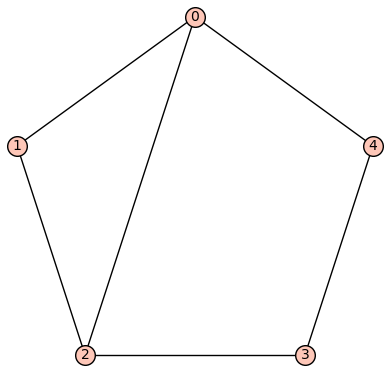

[frozenset(), frozenset({(3, 4)}), frozenset({(0, 4)}), frozenset({(2, 3)})]

In [84]:
def setS(L, e):
    return [x for x in L if not set(e).issubset(set(x)) and set(x).union(set(e)) in L]

def parallel_connection(m, n):
    G = graphs.CycleGraph(m + n - 2)
    G.add_edge(0, m-1)
    edge_e = frozenset({(0, m - 1)})
    return G, edge_e

G, e = parallel_connection(3, 4)
G.show()
M = Matroid(G)
L = list(M.lattice_of_flats())
setS(L, e)

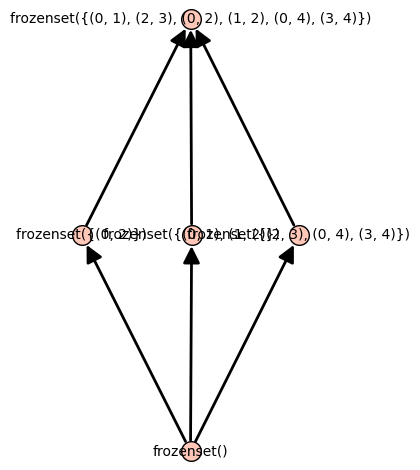

Finite lattice containing 5 elements
[frozenset()]


t

In [86]:
def tau(matroid, S, e):
    tau = [] 
    for F in S:
        modded_matroid = matroid.delete(M.groundset() - F.union(e))
        if modded_matroid.rank() % 2 == 0:
            tau.append(0)
        else:
            tau.append(modded_matroid.lattice_of_flats().kazhdan_lusztig_polynomial().leading_coefficient())
    return tau

def q_tau(matroid, S, e):
    q_tau = [] 
    for F in S:
        modded_matroid = matroid.delete(M.groundset() - F.union(e))
        if modded_matroid.rank() % 2 == 0:
            q_tau.append(0)
        else:
            q_tau.append(kl_inverse_fast(modded_matroid).leading_coefficient())
    return q_tau

def sumat_SetS(M, e):
    dualM = M.dual()
    dualL = dualM.lattice_of_flats()
    dualL.show()
    print(dualL)
    S = setS(list(dualL), e)
    print(S)
    q_t = tau(dualM, S, e)
    sum = 0
    for qt, s in zip(q_t, S):
        sum += qt * t ** ((dualM.rank() - dualM.rank(s))//2) *\
                kl_inverse_fast(dualM.delete(dualM.groundset() - set(s).union(set(e))))
    return sum


sumat_SetS(M, e)